In [2]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.sparse as sp
import anndata as ad
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [5]:
# Import adata_hc.h5ad file
adata_hc = ad.read_h5ad('adata_hc_rann.h5ad')

In [6]:
print(adata_hc)

AnnData object with n_obs × n_vars = 239450 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden', 'neighborhood', 'leiden_expr', 'RANN_ctx'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Leiden_neigh_colors', 'Tier1_colors', 'X_name', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neigh_graph', 'neighborhood', 'neighborhood_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rann_params', 'umap'
    obsm: 'X_neighborhood', 'X_neighborhood_pca', 'X_pca', 'X_rann_comp', 'X_umap', 'X_umap_expr', 'X_umap_neighborhood', 'X_umap_rann', 'neigh_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neigh_graph_connectivities', 'neigh_graph_distance

## Mapping each umap cluster to the spatial plot for all slices

In [17]:
# Ensure the output directory exists
output_dir = "Umap_Cluster_Spatial_Plots"
os.makedirs(output_dir, exist_ok=True)

# Get all unique slice IDs
all_slices = sorted(adata_hc.obs['Slice_ID'].unique())

# Get all cluster labels
clusters = adata_hc.obs['leiden'].astype('category').cat.categories

# Loop over clusters and slices, saving each individually
for cl in clusters:
    for slice_id in all_slices:
        # Subset to this slice
        ad_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice_id]
        x = ad_slice.obs['x'].values
        y = ad_slice.obs['y'].values
        mask = (ad_slice.obs['leiden'] == cl).values

        # Create figure for this cluster/slice
        fig, ax = plt.subplots(figsize=(6, 6), dpi=500)
        
        # Plot all other cells in light gray
        ax.scatter(
            x[~mask], y[~mask],
            c='lightgray', s=1.5, alpha=1, linewidths=0
        )
        # Overlay cells in the cluster in red
        ax.scatter(
            x[mask], y[mask],
            c='red', s=1.5, alpha=1, linewidths=0
        )
        
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f"Cluster {cl} — Slice {slice_id}", fontsize=12)
        
        # Save individual figure
        fname = os.path.join(
            output_dir,
            f"cluster_{cl}_slice_{slice_id}.png"
        )
        fig.savefig(fname, bbox_inches='tight', dpi=500)
        plt.close(fig)

In [18]:
from matplotlib.lines import Line2D

# Ensure output directory exists
output_dir = "Umap_Cluster_Spatial_Plots/All_Clusters_Per_Slice"
os.makedirs(output_dir, exist_ok=True)

# Define your 10 slice IDs (sorted as needed)
all_slices = sorted(adata_hc.obs['Slice_ID'].unique())

# Get cluster labels and colors
cluster_labels = adata_hc.obs['leiden'].astype('category').cat.categories
leiden_colors = adata_hc.uns['leiden_colors']

# Prebuild legend handles once
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=lbl, markerfacecolor=col, markersize=5)
    for lbl, col in zip(cluster_labels, leiden_colors)
]

# Loop over each slice and save a separate plot
for slice_id in all_slices:
    ad_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice_id]
    x = ad_slice.obs['x'].values
    y = ad_slice.obs['y'].values
    clusters = ad_slice.obs['leiden'].values

    # Create figure for this slice
    fig, ax = plt.subplots(figsize=(8, 8), dpi=500)
    
    # Plot each cluster in its assigned color
    for lbl, col in zip(cluster_labels, leiden_colors):
        mask = clusters == lbl
        ax.scatter(
            x[mask], y[mask],
            color=col, s=2, alpha=1, linewidths=0
        )

    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(slice_id, fontsize=12)
    
    # Add legend at right margin of this plot
    ax.legend(
        handles=legend_handles,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False,
        fontsize=6,
        title='Cluster'
    )

    plt.tight_layout()
    
    # Save individual slice plot
    out_fname = os.path.join(output_dir, f"{slice_id}_leiden_spatial.png")
    fig.savefig(out_fname, bbox_inches='tight', dpi=500)
    plt.close(fig)

## Mapping each Tier1 cluster to a spatial plot

In [19]:
# Ensure output directory exists
output_dir = "Umap_Tier1_Spatial_Plots"
os.makedirs(output_dir, exist_ok=True)

# Get all unique slice IDs
all_slices = sorted(adata_hc.obs['Slice_ID'].unique())

# Get all Tier1 labels
tier1_classes = adata_hc.obs['Tier1'].astype('category').cat.categories

# Loop over each Tier1 class and each slice, saving separately
for cls in tier1_classes:
    for slice_id in all_slices:
        # Subset to this slice
        ad_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice_id]
        x = ad_slice.obs['x'].values
        y = ad_slice.obs['y'].values
        mask = (ad_slice.obs['Tier1'] == cls).values

        # Create figure for this Tier1 class & slice
        fig, ax = plt.subplots(figsize=(6, 6), dpi=500)
        
        # Plot all other cells in light gray
        ax.scatter(
            x[~mask], y[~mask],
            c='lightgray', s=1.5, alpha=1, linewidths=0
        )
        # Overlay Tier1-class cells in red
        ax.scatter(
            x[mask], y[mask],
            c='red', s=1.5, alpha=1, linewidths=0
        )
        
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f"Tier1: {cls} — Slice {slice_id}", fontsize=12)
        
        # Save individual figure
        fname = os.path.join(
            output_dir,
            f"Tier1_{cls.replace('/', '-')}_slice_{slice_id}.png"
        )
        fig.savefig(fname, bbox_inches='tight', dpi=500)
        plt.close(fig)

In [20]:
# Ensure output directory exists
output_dir = "Umap_Tier1_Spatial_Plots/All_Tier1_Per_Slice"
os.makedirs(output_dir, exist_ok=True)

# Define your 10 slice IDs (sorted)
all_slices = sorted(adata_hc.obs['Slice_ID'].unique())

# Get Tier1 labels and their colors
tier1_labels = adata_hc.obs['Tier1'].astype('category').cat.categories
tier1_colors = adata_hc.uns['Tier1_colors']

# Prebuild legend handles once
legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=lbl, markerfacecolor=col, markersize=5)
    for lbl, col in zip(tier1_labels, tier1_colors)
]

# Loop over each slice and save a separate plot
for slice_id in all_slices:
    ad_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice_id]
    x = ad_slice.obs['x'].values
    y = ad_slice.obs['y'].values
    tier1 = ad_slice.obs['Tier1'].values

    # Create figure for this slice
    fig, ax = plt.subplots(figsize=(8, 8), dpi=500)
    
    # Plot each Tier1 class in its assigned color
    for lbl, col in zip(tier1_labels, tier1_colors):
        mask = tier1 == lbl
        ax.scatter(
            x[mask], y[mask],
            color=col, s=2, alpha=1, linewidths=0
        )

    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(slice_id, fontsize=12)
    
    # Add legend at right margin of this plot
    ax.legend(
        handles=legend_handles,
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=False,
        fontsize=6,
        title='Tier1'
    )

    plt.tight_layout()
    
    # Save individual slice-level figure
    out_fname = os.path.join(output_dir, f"{slice_id}_tier1_spatial.png")
    fig.savefig(out_fname, bbox_inches='tight', dpi=500)
    plt.close(fig)

## Feature Plot of a few genes on a spatial map

In [18]:
# Create output directory
output_dir = "Feature_Plots_scatter"
os.makedirs(output_dir, exist_ok=True)

# Define your marker list (fill this yourself)
markers = ["Cd19", "Pecam1", "Tubb3", "Vil1", "C3", "Col14a1", "Col1a2", "Dpt", "Pdgfra", "Sparc", "Kit", "Ccl21a", "Lyve1", "Cd68", "Ncam1", "Ptprc", "Sdc1", "Tagln"] 

# Build custom colormap
colors = ["lightgray", "green", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list(
    "BlueGreenYellowRed",
    colors,
    N=256
)

# Select the slice you want to plot
slice_id = '062921_D0_m3a_1_slice_2'
adata_slice = adata_hc[adata_hc.obs['Slice_ID'] == slice_id].copy()

# Extract spatial coordinates
x = adata_slice.obs['x'].values
y = adata_slice.obs['y'].values

# Loop over markers and plot
for gene in markers:
    if gene not in adata_slice.var_names:
        print(f"Warning: {gene} not found in this slice; skipping.")
        continue

    # Extract expression vector
    expr_vec = adata_slice[:, gene].X
    if sp.issparse(expr_vec):
        expr = expr_vec.A.flatten()
    else:
        expr = expr_vec.flatten()

    # Make the plot
    fig, ax = plt.subplots(figsize=(6, 6), dpi=500)
    sc = ax.scatter(
        x, y,
        c=expr,
        cmap=custom_cmap,
        s=1.5,
        alpha=1,
        linewidths=0
    )
    # Add colorbar and formatting
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
    cbar.set_label(f"{gene} expression", rotation=270, labelpad=15)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"Spatial expression — {gene}", fontsize=14)

    # 6d. Save figure
    fname = os.path.join(output_dir, f"{gene}_spatial.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.close(fig)


# Dot Plots for each cluster

In [27]:
# 1. Ensure output directory exists
output_dir = "Cluster_TopMarkers_DotPlots"
os.makedirs(output_dir, exist_ok=True)

# 2. Retrieve the ranking from Scanpy
rg = adata_hc.uns["rank_genes_groups"]

# 3. Prepare a DataFrame for top 20 per cluster
cluster_ids = adata_hc.obs['leiden'].astype('category').cat.categories
top20 = []

for cl in cluster_ids:
    names = rg['names'][cl][:20]
    pvals = rg['pvals_adj'][cl][:20] if 'pvals_adj' in rg else [None]*20
    for gene, lf, pv in zip(names, logfc, pvals):
        top20.append({'cluster': cl, 'gene': gene, 'pval_adj': pv})

df_top20 = pd.DataFrame(top20)
# Save to CSV
df_top20.to_csv(os.path.join(output_dir, "top20_per_cluster.csv"), index=False)

# Generate dot plot per cluster (top 10 genes)
for cl in cluster_ids:
    top10 = df_top20[df_top20['cluster'] == cl]['gene'][:10].tolist()
    subset = adata_hc[adata_hc.obs['leiden'] == cl]
    sc.pl.dotplot(
        subset,
        var_names=top10,
        groupby='leiden',
        standard_scale='var',
        title=f"Cluster {cl} — Top 10 markers",
        show=False
    )

    fname = os.path.join(output_dir, f"cluster_{cl}_top10_markers_dotplot.png")
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

# Spatial Neighborhoods

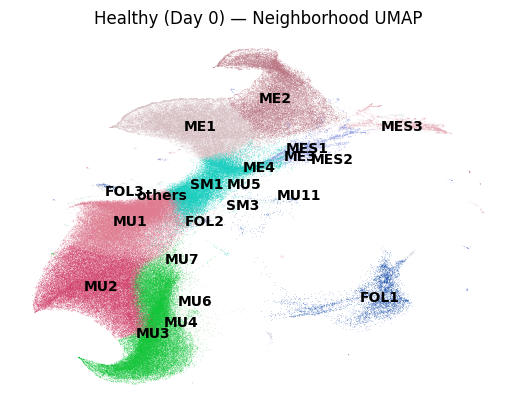

In [4]:
adata_hc.obsm['neigh_umap'] = adata_hc.obs[['Neigh_umap_x','Neigh_umap_y']].values

# 2. Plot neighborhood UMAP
sc.pl.embedding(
    adata_hc,
    basis='neigh_umap',
    color='Leiden_neigh',
    title='Healthy (Day 0) — Neighborhood UMAP',
    frameon=False,
    legend_loc='on data'
)

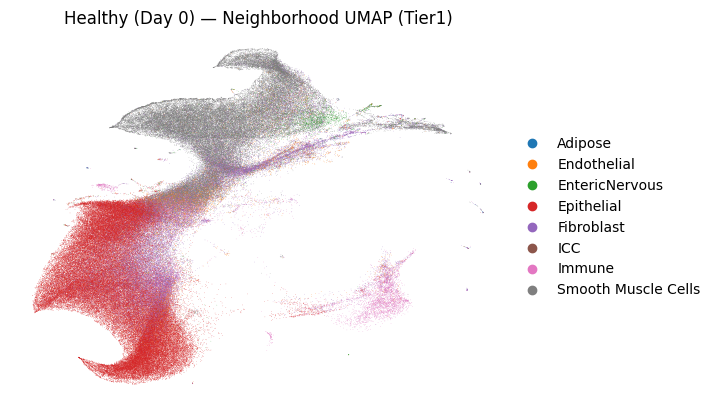

In [5]:
# color by Tier1 classes:
sc.pl.embedding(
    adata_hc,
    basis='neigh_umap',
    color='Tier1',
    title='Healthy (Day 0) — Neighborhood UMAP (Tier1)',
    frameon=False,
    legend_loc='right margin'
)

In [4]:
# --- Ensure clean categories (no NaNs) ---
for col in ["Tier1", "Tier3", "Slice_ID"]:
    adata_hc.obs[col] = adata_hc.obs[col].astype("category")
for col in ["Tier1", "Tier3"]:
    if adata_hc.obs[col].isna().any():
        adata_hc.obs[col] = adata_hc.obs[col].cat.add_categories(["Unknown"]).fillna("Unknown")

tier1_cats = list(adata_hc.obs["Tier1"].cat.categories)
tier3_cats = list(adata_hc.obs["Tier3"].cat.categories)
t1_codes_all = adata_hc.obs["Tier1"].cat.codes.values
t3_codes_all = adata_hc.obs["Tier3"].cat.codes.values

n_cells = adata_hc.n_obs
n1, n3 = len(tier1_cats), len(tier3_cats)
k = 40

# Weighted composition matrices
comp_t1 = np.zeros((n_cells, n1), dtype=np.float32)
comp_t3 = np.zeros((n_cells, n3), dtype=np.float32)

# Precompute (closest=1.0 ... furthest=1/k)
# We'll adapt if a slice has < k+1 cells.
base_weights = np.arange(k, 0, -1, dtype=np.float32) / k  # [1, 39/40, ..., 1/40]


In [5]:
# --- Do it per slice (like the paper) ---
for sid in adata_hc.obs["Slice_ID"].cat.categories:
    mask = (adata_hc.obs["Slice_ID"] == sid).values
    if not mask.any():
        continue

    idx_global = np.where(mask)[0]
    coords = adata_hc.obs.loc[mask, ["x", "y"]].values
    if coords.shape[0] < 2:
        continue

    tree = KDTree(coords)
    # k_eff handles tiny slices gracefully
    k_eff = min(k, coords.shape[0] - 1)
    dist, ind = tree.query(coords, k=k_eff + 1)

    # drop self (first column)
    ind = ind[:, 1:]

    # map neighbor row indices back to global indices
    neigh_global = idx_global[ind]                         # (n_slice_cells, k_eff)

    # neighbor labels as integer codes
    neigh_t1 = t1_codes_all[neigh_global]                  # same shape
    neigh_t3 = t3_codes_all[neigh_global]

    # weights for this slice (length k_eff)
    weights = base_weights[:k_eff]                         # [1, 39/40, ..., up to length k_eff]

    # add weighted counts into composition matrices
    rows = np.repeat(idx_global, k_eff)                    # row index per neighbor
    wvals = np.tile(weights, len(idx_global))              # weights flattened

    np.add.at(comp_t1, (rows, neigh_t1.flatten()), wvals)
    np.add.at(comp_t3, (rows, neigh_t3.flatten()), wvals)


In [6]:
# Tier3 gets scaled by 0.5 (paper)
comp_t3 *= 0.5

# Concatenate: [Tier1 | Tier3x0.5]
features = np.concatenate([comp_t1, comp_t3], axis=1).astype(np.float32)

# Add uniform noise 0.01–0.1 (paper)
rng = np.random.default_rng(0)
features += rng.uniform(0.01, 0.1, size=features.shape).astype(np.float32)

# Sanity: ensure finite
assert np.isfinite(features).all()

# Store the neighborhood vectors
adata_hc.obsm["X_neighborhood"] = features

# PCA on composition vectors; keep all components up to feature dim (80)
n_comps = min(features.shape[1], 80)
Xn_pca = PCA(n_components=n_comps, svd_solver="full", random_state=0).fit_transform(features)
adata_hc.obsm["X_neighborhood_pca"] = Xn_pca

In [7]:
# Graph on PCA of neighborhood vectors (15 neighbors), Leiden 0.5, UMAP
sc.pp.neighbors(adata_hc, use_rep="X_neighborhood_pca", n_neighbors=15, key_added="neigh_graph")
sc.tl.leiden(adata_hc, neighbors_key="neigh_graph", resolution=0.5, key_added="neighborhood")
sc.tl.umap(adata_hc, neighbors_key="neigh_graph")
adata_hc.obsm["X_umap_neighborhood"] = adata_hc.obsm["X_umap"].copy()

print("Number of neighborhoods:", adata_hc.obs["neighborhood"].nunique())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/t3/473q526951s_6zvhy3t8bxzm0000gn/T/ipykernel_5242/3275060313.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hc, neighbors_key="neigh_graph", resolution=0.5, key_added="neighborhood")


Number of neighborhoods: 28


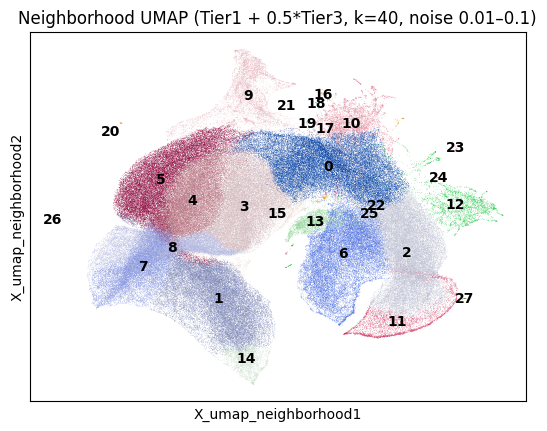

In [8]:
# --- Plots ---
# UMAP of neighborhoods
sc.pl.embedding(
    adata_hc,
    basis="X_umap_neighborhood",
    color="neighborhood",
    title="Neighborhood UMAP (Tier1 + 0.5*Tier3, k=40, noise 0.01–0.1)",
    legend_loc="on data"
)

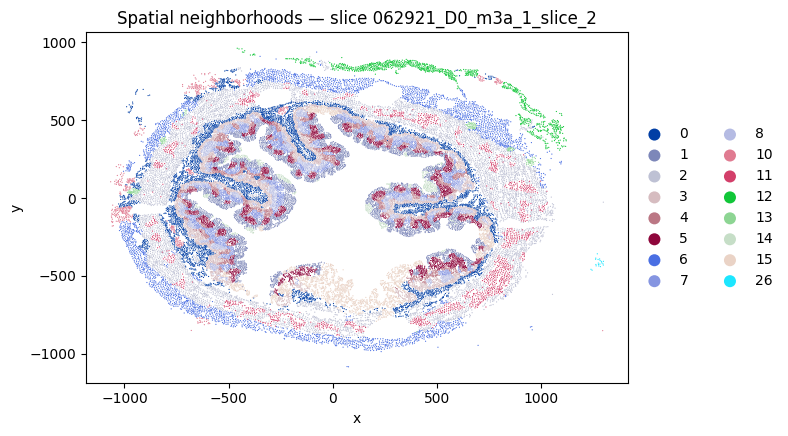

In [9]:
# Spatial plot for one slice
slice0 = adata_hc.obs["Slice_ID"].unique()[0]
adata_slice = adata_hc[adata_hc.obs["Slice_ID"] == slice0].copy()
sc.pl.scatter(
    adata_slice,
    x="x",
    y="y",
    color="neighborhood",
    size=3,
    alpha=1,
    title=f"Spatial neighborhoods — slice {slice0}",
    legend_loc="right margin"
)

In [17]:
print(adata_hc)

AnnData object with n_obs × n_vars = 239450 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden', 'neighborhood'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Leiden_neigh_colors', 'Tier1_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'neigh_graph', 'neighborhood', 'neighborhood_colors'
    obsm: 'X_pca', 'X_umap', 'neigh_umap', 'X_neighborhood', 'X_neighborhood_pca', 'X_umap_neighborhood'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neigh_graph_distances', 'neigh_graph_connectivities'


In [18]:
# retrieving expression umap, lieden and neighbors
old_adata = ad.read_h5ad('adata_hc.h5ad')
adata_hc.obsm['X_umap_expr'] = old_adata.obsm['X_umap'].copy()
adata_hc.obs['leiden_expr'] = old_adata.obs['leiden'].copy()

In [20]:
# save the updated adata_hc
adata_hc.write('adata_hc.h5ad')

### RANN NEIGHBORHOOD visualizarion (computed in R)

In [2]:
# Load the file you wrote from R
adata = sc.read_h5ad("adata_hc_rann.h5ad")
print(adata)
print("obs columns (first 10):", list(adata.obs.columns)[:10])
print("obsm keys:", list(adata.obsm.keys()))
print("uns keys (subset):", [k for k in adata.uns.keys() if "rann" in k.lower()])


AnnData object with n_obs × n_vars = 239450 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden', 'neighborhood', 'leiden_expr', 'RANN_ctx'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Leiden_neigh_colors', 'Tier1_colors', 'X_name', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neigh_graph', 'neighborhood', 'neighborhood_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rann_params', 'umap'
    obsm: 'X_neighborhood', 'X_neighborhood_pca', 'X_pca', 'X_rann_comp', 'X_umap', 'X_umap_expr', 'X_umap_neighborhood', 'X_umap_rann', 'neigh_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'neigh_graph_connectivities', 'neigh_graph_distance

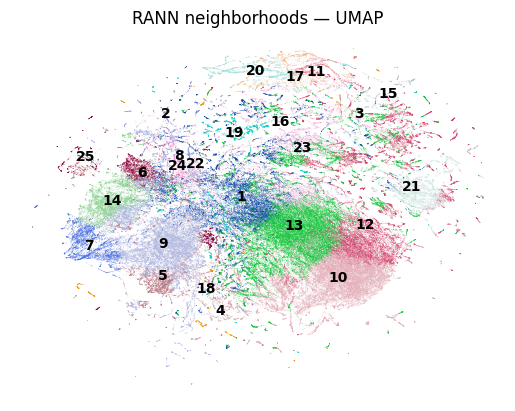

In [3]:
# UMAP plot of RANN neighborhoods
#    Uses the coordinates saved under obsm['X_umap_rann'] and colors by obs['RANN_ctx']
sc.pl.embedding(
    adata,
    basis="X_umap_rann",
    color="RANN_ctx",
    legend_loc="on data",
    title="RANN neighborhoods — UMAP",
    frameon=False
)

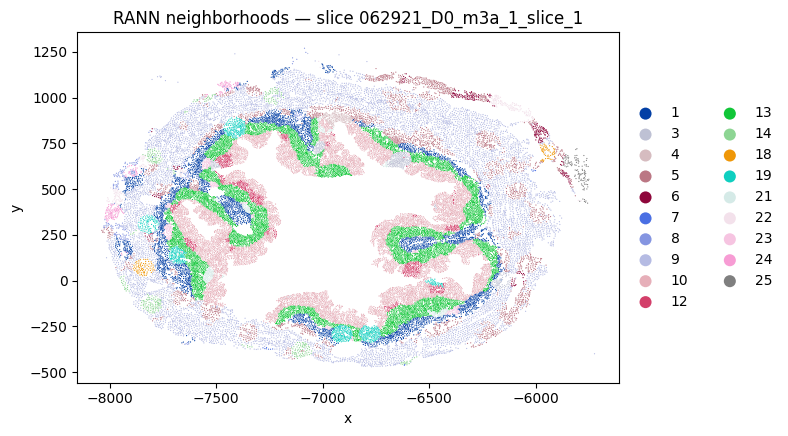

In [4]:
# Spatial plot for one slice
#    Pick a slice ID that exists in your obs['Slice_ID']
if "Slice_ID" in adata.obs.columns:
    # choose one deterministically
    slice_id = adata.obs["Slice_ID"].cat.categories[0] if hasattr(adata.obs["Slice_ID"].dtype, "categories") else adata.obs["Slice_ID"].unique()[0]
    adata_slice = adata[adata.obs["Slice_ID"] == slice_id].copy()

    sc.pl.scatter(
        adata_slice,
        x="x",
        y="y",
        color="RANN_ctx",
        size=3,
        alpha=1.0,
        title=f"RANN neighborhoods — slice {slice_id}",
        legend_loc="right margin"
    )
else:
    print("Slice_ID not found in obs; skipping spatial plot.")

# Detailed Analysis of subclusters 5, 6, 14, 13, and subclusters 1, 4, 11

In [21]:
fb_clusters  = ['5','6','14','13']   # fibroblast-ish set
smc_clusters = ['1','4','11']        # SMC-ish set
label_col = 'leiden_expr'

adata_hc_fb  = adata_hc[adata_hc.obs[label_col].isin(fb_clusters)].copy()
adata_hc_smc = adata_hc[adata_hc.obs[label_col].isin(smc_clusters)].copy()

In [3]:
# import data
adata_hc_fb = ad.read_h5ad('adata_hc_fb.h5ad')
adata_hc_smc = ad.read_h5ad('adata_hc_smc.h5ad')

### Subclustering fb and smc

In [22]:
def recluster_expression(adata_sub, n_top_genes=2000, n_pcs=50, n_neighbors=15,
                         leiden_res=0.8, leiden_key='leiden_sub', neighbors_key='expr_neighbors'):
    # HVGs on the subset (works fine on log1p-normalized data)
    sc.pp.highly_variable_genes(adata_sub, flavor='seurat', n_top_genes=n_top_genes)
    sc.pp.scale(adata_sub, zero_center=True, max_value=10)
    sc.tl.pca(adata_sub, n_comps=min(n_pcs, adata_sub.n_vars), use_highly_variable=True, svd_solver='arpack')

    sc.pp.neighbors(adata_sub, n_neighbors=n_neighbors, n_pcs=min(n_pcs, adata_sub.varm['PCs'].shape[1]),
                    key_added=neighbors_key)
    sc.tl.leiden(adata_sub, neighbors_key=neighbors_key, resolution=leiden_res, key_added=leiden_key)
    sc.tl.umap(adata_sub, neighbors_key=neighbors_key)
    adata_sub.obsm['X_umap_expr'] = adata_sub.obsm['X_umap'].copy()
    return adata_sub

In [23]:
# Recluster + UMAP (expression) for both
adata_hc_fb  = recluster_expression(adata_hc_fb,  n_top_genes=2000, n_pcs=50, n_neighbors=15,
                                    leiden_res=0.8, leiden_key='leiden_fb',  neighbors_key='expr_neighbors_fb')
adata_hc_smc = recluster_expression(adata_hc_smc, n_top_genes=2000, n_pcs=50, n_neighbors=15,
                                    leiden_res=0.8, leiden_key='leiden_smc', neighbors_key='expr_neighbors_smc')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:307: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  return fn(*args_all, **kw)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/prepro

In [36]:
# Create the folder to save images
output_dir = 'subcluster_Plots'
os.makedirs(output_dir, exist_ok=True)

# Helper function to plot and save with adjusted figure size
def plot_and_save(adata, basis, color, title, filename, width=8, height=6):
    sc.pl.embedding(adata, basis=basis, color=color, title=title, show=False)
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    plt.tight_layout()         # Adjust layout to prevent clipping
    plt.savefig(os.path.join(output_dir, filename), dpi=500)
    plt.close()

# FB: Expression UMAP (leiden_fb)
plot_and_save(adata_hc_fb, 'X_umap_expr', 'leiden_fb', 'FB: Expression UMAP (leiden_fb)', 'FB_Expression_UMAP_leiden_fb.png')

# SMC: Expression UMAP (leiden_smc)
plot_and_save(adata_hc_smc, 'X_umap_expr', 'leiden_smc', 'SMC: Expression UMAP (leiden_smc)', 'SMC_Expression_UMAP_leiden_smc.png')

# FB: Tier1
plot_and_save(adata_hc_fb, 'X_umap_expr', 'Tier1', 'FB: Tier1', 'FB_Tier1.png')

# SMC: Tier1
plot_and_save(adata_hc_smc, 'X_umap_expr', 'Tier1', 'SMC: Tier1', 'SMC_Tier1.png')

# FB: Tier3
plot_and_save(adata_hc_fb, 'X_umap_expr', 'Tier3', 'FB: Tier3', 'FB_Tier3.png', 16)

# SMC: Tier3
plot_and_save(adata_hc_smc, 'X_umap_expr', 'Tier3', 'SMC: Tier3', 'SMC_Tier3.png', 16)

In [25]:
# top 20 per new cluster, save CSVs; dotplots of top 5
def rank_markers_and_export(adata_sub, groupby, key_added, csv_path, top_n=20, dotplot_top=5):
    # Wilcoxon rank-sum per cluster
    sc.tl.rank_genes_groups(adata_sub, groupby=groupby, method='wilcoxon', key_added=key_added)
    df = sc.get.rank_genes_groups_df(adata_sub, key=key_added, group=None)
    # score-descending per group; keep top N
    df_top = (df.sort_values(['group','scores'], ascending=[True, False])
                .groupby('group', as_index=False, sort=False)
                .head(top_n))
    df_top.to_csv(csv_path, index=False)
    # Dotplot of top 5 per cluster
    sc.pl.rank_genes_groups_dotplot(adata_sub, n_genes=dotplot_top, key=key_added, groupby=groupby)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes

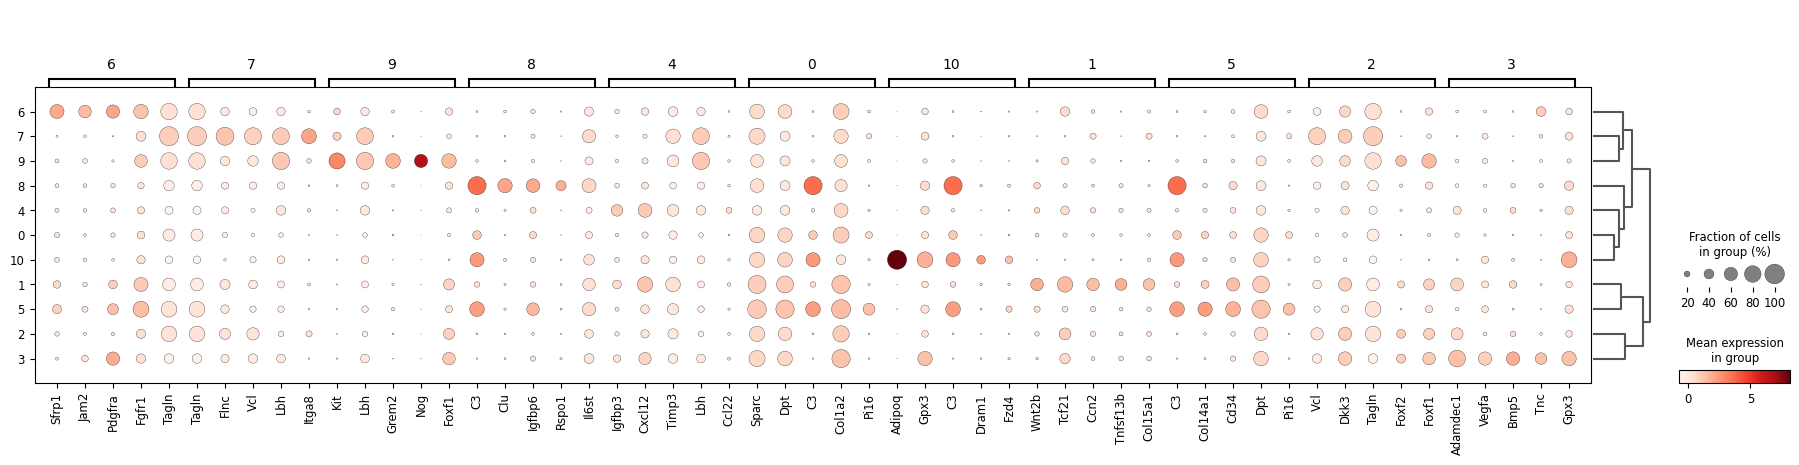

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scanpy/tools/_rank_genes

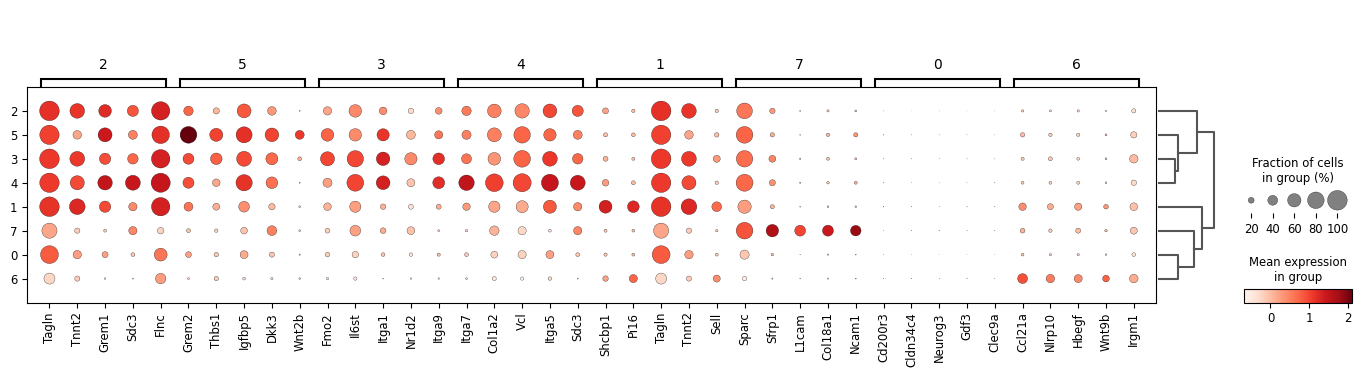

In [26]:
# Fibroblast-like subset
rank_markers_and_export(adata_hc_fb,
                        groupby='leiden_fb',
                        key_added='rank_genes_fb',
                        csv_path='fb_top20_markers.csv',
                        top_n=20, dotplot_top=5)

# SMC-like subset
rank_markers_and_export(adata_hc_smc,
                        groupby='leiden_smc',
                        key_added='rank_genes_smc',
                        csv_path='smc_top20_markers.csv',
                        top_n=20, dotplot_top=5)

### Project subcluster labels to full healthy umap

In [39]:
# Helper to project subset labels back to the full object with gray background for non-members
def project_subset_labels_to_full(full_adata, subset_adata, subset_label_col, new_col_name, palette_name='tab20'):
    # Start with NaNs (these will be plotted as gray)
    full_adata.obs[new_col_name] = np.nan
    # Assign subcluster labels (as strings) to the matching cells
    full_adata.obs.loc[subset_adata.obs_names, new_col_name] = subset_adata.obs[subset_label_col].astype(str).values
    # Make categorical so Scanpy treats colors correctly
    full_adata.obs[new_col_name] = full_adata.obs[new_col_name].astype('category')

    # Optional: set a palette for the categories (NaNs use na_color in plotting)
    try:
        import seaborn as sns
        cats = list(full_adata.obs[new_col_name].cat.categories)
        pal = sns.color_palette(palette_name, n_colors=len(cats)).as_hex()
        full_adata.uns[f'{new_col_name}_colors'] = pal
    except Exception:
        pass

# project FB and SMC subcluster labels onto the full object
project_subset_labels_to_full(adata_hc, adata_hc_fb,  'leiden_fb',  'fb_subcluster',  palette_name='tab20')
project_subset_labels_to_full(adata_hc, adata_hc_smc, 'leiden_smc', 'smc_subcluster', palette_name='tab20')

/var/folders/t3/473q526951s_6zvhy3t8bxzm0000gn/T/ipykernel_5242/2602790587.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3' '3' '4' ... '0' '0' '0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_adata.obs.loc[subset_adata.obs_names, new_col_name] = subset_adata.obs[subset_label_col].astype(str).values
/var/folders/t3/473q526951s_6zvhy3t8bxzm0000gn/T/ipykernel_5242/2602790587.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['6' '6' '0' ... '0' '0' '0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_adata.obs.loc[subset_adata.obs_names, new_col_name] = subset_adata.obs[subset_label_col].astype(str).values


In [ ]:
output_dir = 'subcluster_Plots'
os.makedirs(output_dir, exist_ok=True)

# Helper function to plot and save with adjusted figure size
def plot_and_save(adata, basis, color, title, filename, na_color='#E5E5E5', legend_loc='on data', size=2):
    sc.pl.embedding(
        adata,
        basis=basis,
        color=color,
        na_color=na_color,
        title=title,
        legend_loc=legend_loc,
        size=size,
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(8, 6)  # Adjust figure size to prevent cropping
    plt.tight_layout()         # Adjust layout to prevent clipping
    plt.savefig(os.path.join(output_dir, filename), dpi=500)
    plt.close()

# Plot FB subclusters on the old expression UMAP
plot_and_save(
    adata=adata_hc,
    basis='X_umap_expr',
    color='fb_subcluster',
    title='Old Expression UMAP — FB subclusters',
    filename='FB_subclusters_old_expression_UMAP.png'
)

# Plot SMC subclusters on the old expression UMAP
plot_and_save(
    adata=adata_hc,
    basis='X_umap_expr',
    color='smc_subcluster',
    title='Old Expression UMAP — SMC subclusters',
    filename='SMC_subclusters_old_expression_UMAP.png'
)


### Marker Feature Plot

In [3]:
# Helper function to plot and save with adjusted figure size
def plot_and_save(adata, basis, color, title, filename, color_map=None, vmax=None, vmin=None, frameon=False):
    sc.pl.embedding(
        adata,
        basis=basis,
        color=color,
        color_map=color_map,
        title=title,
        vmax=vmax,
        vmin=vmin,
        frameon=frameon,
        show=False
    )
    fig = plt.gcf()
    fig.set_size_inches(8, 6)  # Adjust figure size to prevent cropping
    plt.tight_layout()         # Adjust layout to prevent clipping
    plt.savefig(os.path.join(output_dir, filename), dpi=500)
    plt.close()

In [7]:
# Create the folder to save images
output_dir = 'subcluster_Plots'
os.makedirs(output_dir, exist_ok=True)

# Define custom colormap
colors = ["lightgray", "green", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list("BlueGreenYellowRed", colors, N=256)

# Gene to visualize
gene = "Lpar1"

# FB-like subset plot
plot_and_save(
    adata=adata_hc_fb,
    basis="X_umap_expr",
    color=gene,
    title=f"FB subclusters — {gene} (expression UMAP)",
    filename=f"FB_subclusters_{gene}_expression_UMAP.png",
    color_map=custom_cmap,
    vmax=None,
    vmin=None,
    frameon=False
)

# SMC-like subset plot
plot_and_save(
    adata=adata_hc_smc,
    basis="X_umap_expr",
    color=gene,
    title=f"SMC subclusters — {gene} (expression UMAP)",
    filename=f"SMC_subclusters_{gene}_expression_UMAP.png",
    color_map=custom_cmap,
    vmax=None,
    vmin=None,
    frameon=False
)


In [8]:
# Create the folder to save images
output_dir = 'subcluster_Plots'
os.makedirs(output_dir, exist_ok=True)

# Define custom colormap
colors = ["lightgray", "green", "yellow", "red"]
custom_cmap = LinearSegmentedColormap.from_list("BlueGreenYellowRed", colors, N=256)

# Gene to visualize
gene = "Lpar1"

# FB-like subset plot
plot_and_save(
    adata=adata_hc,
    basis="X_umap_expr",
    color=gene,
    title=f"{gene} expression UMAP",
    filename=f"{gene}_expression_UMAP.png",
    color_map=custom_cmap,
    vmax=None,
    vmin=None,
    frameon=False
)

### All Markers Feature Plots

In [7]:
# Define four anchor colors
colors = ["lightgray", "green", "yellow", "red"]

custom_cmap = LinearSegmentedColormap.from_list(
    "BlueGreenYellowRed",
    colors,     
    N=256  
)

output_dir = "Feature Plots SMC"
os.makedirs(output_dir, exist_ok=True)

# marker dictionary
celltype_markers = {
    "EntericNervous":   ["Tubb3", "Nos1"],
    "ICC":              ["Kit", "Ano2", "Ano1"],
    "Pericyte":         ["Rgs5", "Pdgfrb", "Adipoq", "Jam2", "Ngf", "Gdf10", "Scara5"],
    "SMC":              ["Myh11", "Actg2", "Myocd", "Des", "Acta2", "Tagln"],
    "Fibroblast":       [
        "Pdgfra", "Sparc", "Dcn", "Lum", "Col1a1", "Col1a2", "Col14a1", "Fgfr2",
        "Col3a1", "Col4a5", "Col4a6", "Bmp5", "Bmp4", "Grem1", "Vcam1",
        "Ogn", "Mgp", "Sfrp2", "C3", "Dpt", "Col15a1", "Cd34", "Pi16", "Ackr4",
        "Col18a1", "Mmp3", "Mmp10", "Mmp13", "Plau", "Il11",
        "Tnc", "Cilp", "Pcolce2", "Tcf21", "Inmt", "Rspo1", "Foxl1",
        "Cxcl13", "Ccl19", "Prlr", "Ptn"
    ],
    "Mesothelial":      ["Msln", "Wt1"]
}

# Loop and plot
for celltype, genes in celltype_markers.items():
    for gene in genes:
        if gene not in adata_hc_smc.var_names:
            print(f"Warning: {gene} not found in adata_hc; skipping.")
            continue
        # Plot UMAP for that gene
        fig = sc.pl.umap(
            adata_hc_smc,
            color=gene,
            cmap=custom_cmap,
            size=1,
            alpha=1,
            vmin=0,
            vmax="p99",
            title=f"UMAP — {celltype} {gene}",
            show=False, # do not display interactively
            return_fig=True
        )
        # Save figure
        filename = f"{celltype}_{gene}.png"
        filepath = os.path.join(output_dir, filename)
        fig.savefig(filepath, dpi=300, bbox_inches='tight') 
        plt.close(fig)

### Slice Feature Plot Overlay for adata_hc, adata_hc_fb and adata_hc_smc

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -------- settings --------
out_root = "SliceUMAP_byCluster"
dpi = 300
bg_color = "lightgray"
bg_alpha = 0.35
bg_size = 1.2
fg_size = 1.6
os.makedirs(out_root, exist_ok=True)

def keys_for(name: str):
    if name.endswith("_fb"):
        return "leiden_fb", "leiden_fb_colors"
    if name.endswith("_smc"):
        return "leiden_smc", "leiden_smc_colors"
    return "leiden", "leiden_colors"   # adata_hc

datasets = []
for name in ("adata_hc", "adata_hc_fb", "adata_hc_smc"):
    if name in globals():
        datasets.append((name, globals()[name]))

for ds_name, ad in datasets:
    cluster_key, palette_key = keys_for(ds_name)

    if "X_umap_expr" not in ad.obsm_keys():
        raise KeyError(f"{ds_name}: missing obsm['X_umap_expr']")
    if cluster_key not in ad.obs:
        raise KeyError(f"{ds_name}: missing obs['{cluster_key}']")
    if palette_key not in ad.uns:
        raise KeyError(f"{ds_name}: missing uns['{palette_key}']")

    # categories & palette (keep order as in categories!)
    ad.obs[cluster_key] = ad.obs[cluster_key].astype("category")
    labels_all = list(ad.obs[cluster_key].cat.categories)
    colors_all = list(ad.uns[palette_key])
    if len(colors_all) != len(labels_all):
        raise ValueError(f"{ds_name}: palette length != number of categories for {cluster_key}")

    color_map = dict(zip(labels_all, colors_all))

    # coords and arrays
    umap = ad.obsm["X_umap_expr"]
    ux, uy = umap[:, 0], umap[:, 1]
    cl_arr = ad.obs[cluster_key].values

    ds_dir = os.path.join(out_root, ds_name)
    os.makedirs(ds_dir, exist_ok=True)
    for sid in sorted(ad.obs["Slice_ID"].unique()):
        mask_slice = (ad.obs["Slice_ID"] == sid).values

        fig, ax = plt.subplots(figsize=(6, 6), dpi=dpi)

        # background (other slices)
        ax.scatter(
            ux[~mask_slice], uy[~mask_slice],
            c=bg_color, s=bg_size, alpha=bg_alpha, linewidths=0, rasterized=True
        )

        # overlay: cells from this slice, colored by cluster
        present_labels = []
        for lbl in labels_all:           # preserve category order
            m = mask_slice & (cl_arr == lbl)
            if np.any(m):
                present_labels.append(lbl)
                ax.scatter(
                    ux[m], uy[m],
                    c=[color_map[lbl]], s=fg_size, alpha=0.95, linewidths=0, rasterized=True
                )

        ax.set_aspect("equal"); ax.axis("off")
        ax.set_title(f"{ds_name} — {sid}", fontsize=12)

        # per-plot legend (right margin) using only present labels
        legend_handles = [
            Line2D([0],[0], marker='o', color='w',
                   label=str(lbl), markerfacecolor=color_map[lbl],
                   markeredgecolor='none', markersize=6)
            for lbl in present_labels
        ]
        ax.legend(handles=legend_handles, loc='center left',
                  bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=6, title=cluster_key)

        plt.tight_layout()
        out_path = os.path.join(ds_dir, f"{ds_name}_slice_{sid}_UMAPexpr_byCluster.png")
        plt.savefig(out_path, bbox_inches="tight", dpi=dpi)
        plt.close(fig)

In [34]:
print(adata_hc_fb)

AnnData object with n_obs × n_vars = 35922 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden', 'neighborhood', 'leiden_expr', 'leiden_fb'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'Leiden_neigh_colors', 'Tier1_colors', 'Tier3_colors', 'dendrogram_leiden', 'dendrogram_leiden_fb', 'expr_neighbors_fb', 'hvg', 'leiden', 'leiden_colors', 'leiden_fb', 'leiden_fb_colors', 'log1p', 'neigh_graph', 'neighborhood', 'neighborhood_colors', 'neighbors', 'pca', 'rank_genes_fb', 'rank_genes_groups', 'umap'
    obsm: 'X_neighborhood', 'X_neighborhood_pca', 'X_pca', 'X_umap', 'X_umap_expr', 'X_umap_neighborhood', 'neigh_umap'
    varm: 'PCs'
 

### Spatial Neighborhood Analysis

In [ ]:
# neighborhood UMAP for subsets
def neighborhood_umap_for_subset(adata_sub, neigh_rep_key='X_neighborhood_pca',
                                 neighbors_key='neigh_graph', leiden_key=None, leiden_res=None):
    if neigh_rep_key not in adata_sub.obsm:
        print(f"[warn] {neigh_rep_key} not found; skipping neighborhood UMAP for this subset.")
        return adata_sub
    sc.pp.neighbors(adata_sub, use_rep=neigh_rep_key, n_neighbors=15, key_added=neighbors_key)
    if leiden_key is not None and leiden_res is not None:
        sc.tl.leiden(adata_sub, neighbors_key=neighbors_key, resolution=leiden_res, key_added=leiden_key)
    sc.tl.umap(adata_sub, neighbors_key=neighbors_key)
    adata_sub.obsm['X_umap_neighborhood'] = adata_sub.obsm['X_umap'].copy()
    return adata_sub

In [ ]:
# Neighborhood UMAP for both (optional but requested) (This uses your previously computed X_neighborhood_pca carried into the subset)
adata_hc_fb  = neighborhood_umap_for_subset(adata_hc_fb,  neigh_rep_key='X_neighborhood_pca',
                                            neighbors_key='neigh_graph_fb',
                                            leiden_key=None, leiden_res=None)
adata_hc_smc = neighborhood_umap_for_subset(adata_hc_smc, neigh_rep_key='X_neighborhood_pca',
                                            neighbors_key='neigh_graph_smc',
                                            leiden_key=None, leiden_res=None)

In [ ]:
if 'X_umap_neighborhood' in adata_hc_fb.obsm:
    sc.pl.embedding(adata_hc_fb, basis='X_umap_neighborhood',
                    color=['leiden_fb'], title=['FB: Neighborhood UMAP (colored by leiden_fb)'])

if 'X_umap_neighborhood' in adata_hc_smc.obsm:
    sc.pl.embedding(adata_hc_smc, basis='X_umap_neighborhood',
                    color=['leiden_smc'], title=['SMC: Neighborhood UMAP (colored by leiden_smc)'])

### Save objects

In [37]:
adata_hc_fb.write('adata_hc_fb.h5ad')
adata_hc_smc.write('adata_hc_smc.h5ad')

# Neighborhood Composition Per Cell Type

In [4]:
print(adata_hc_smc)
print(adata_hc_fb)

AnnData object with n_obs × n_vars = 67214 × 990
    obs: 'x', 'y', 'Mouse_ID', 'Technical_repeat_number', 'Sample_type', 'Slice_ID', 'FOV', 'Cell_ID', 'sample', 'N_genes', 'Tier1', 'Tier2', 'Tier3', 'Leiden_neigh', 'Neigh_umap_x', 'Neigh_umap_y', 'Tier2_umap_x', 'Tier2_umap_y', 'Tier3_umap_x', 'Tier3_umap_y', 'Tier1_umap_x', 'Tier1_umap_y', 'leiden', 'neighborhood', 'leiden_expr', 'leiden_smc'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'Leiden_neigh_colors', 'Tier1_colors', 'Tier3_colors', 'dendrogram_leiden', 'dendrogram_leiden_smc', 'expr_neighbors_smc', 'hvg', 'leiden', 'leiden_colors', 'leiden_smc', 'leiden_smc_colors', 'log1p', 'neigh_graph', 'neighborhood', 'neighborhood_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_smc', 'umap'
    obsm: 'X_neighborhood', 'X_neighborhood_pca', 'X_pca', 'X_umap', 'X_umap_expr', 'X_umap_neighborhood', 'neigh_umap'
    varm: '

In [6]:
import seaborn as sns

k = 15                       # number of nearest neighbors (rank depth)
focal_col   = "leiden_fb"       # e.g., "leiden", "leiden_expr", "Tier1", "Tier3"
neighbor_col= "leiden_fb"        # e.g., "Tier3", "Tier1", another clustering
topN = 12                    # keep top neighbor labels in plots; rest -> "Other"
outdir = f"rank_profiles_{focal_col}_vs_{neighbor_col}_FB"

In [7]:
# ===========================
# PREP: ensure categories
# ===========================
assert "Slice_ID" in adata_hc_fb.obs.columns, "Need obs['Slice_ID']"
for col in [focal_col, neighbor_col]:
    assert col in adata_hc_fb.obs.columns, f"obs['{col}'] missing"
    c = adata_hc_fb.obs[col].astype("category")
    if c.isna().any():
        c = c.cat.add_categories(["Unknown"]).fillna("Unknown")
    adata_hc_fb.obs[col] = c

focal_cats    = list(adata_hc_fb.obs[focal_col].cat.categories)
neighbor_cats = list(adata_hc_fb.obs[neighbor_col].cat.categories)
n_focal, n_neighbor = len(focal_cats), len(neighbor_cats)

focal_codes_all    = adata_hc_fb.obs[focal_col].cat.codes.to_numpy()          # 0..n_focal-1
neighbor_codes_all = adata_hc_fb.obs[neighbor_col].cat.codes.to_numpy()       # 0..n_neighbor-1

In [8]:
# ===========================
# CORE: compute rank profiles
# per focal label, per slice
# ===========================
def compute_rank_profiles(adata, k, focal_col, neighbor_col):
    focal_cats    = list(adata.obs[focal_col].cat.categories)
    neighbor_cats = list(adata.obs[neighbor_col].cat.categories)
    focal_codes_all    = adata.obs[focal_col].cat.codes.to_numpy()
    neighbor_codes_all = adata.obs[neighbor_col].cat.codes.to_numpy()

    # per-focal accumulators
    counts = {f: np.zeros((len(neighbor_cats), k), dtype=np.int64) for f in focal_cats}
    dist_sum = {f: np.zeros(k, dtype=float) for f in focal_cats}
    dist_n   = {f: np.zeros(k, dtype=int)   for f in focal_cats}

    for sid in adata.obs["Slice_ID"].astype("category").cat.categories:
        mask = (adata.obs["Slice_ID"] == sid).values
        idx_global = np.where(mask)[0]
        if idx_global.size < 2:
            continue

        coords = adata.obs.loc[mask, ["x","y"]].to_numpy()
        k_eff = min(k, coords.shape[0]-1)
        if k_eff < 1:
            continue

        # kNN in Euclidean space (ordered)
        tree = KDTree(coords)
        dist, ind = tree.query(coords, k=k_eff+1)
        dist, ind = dist[:,1:], ind[:,1:]                        # drop self

        neigh_global = idx_global[ind]                           # shape [n_slice, k_eff]
        neigh_neighbor_codes = neighbor_codes_all[neigh_global]  # neighbor labels (0..n_neighbor-1)
        neigh_dists          = dist

        # loop through focal labels present on this slice
        slice_focal_codes = focal_codes_all[idx_global]
        for f_idx, f_lab in enumerate(focal_cats):
            focal_mask = (slice_focal_codes == f_idx)
            if not focal_mask.any():
                continue

            foc_lab = f_lab
            nc_foc  = neigh_neighbor_codes[focal_mask, :]       # (n_focal_cells_in_slice, k_eff)
            nd_foc  = neigh_dists[focal_mask, :]                # distances

            # rank-wise accumulate
            for j in range(k_eff):
                col_codes = nc_foc[:, j]
                cnt = np.bincount(col_codes, minlength=len(neighbor_cats))
                counts[foc_lab][:, j] += cnt

                dj = nd_foc[:, j]
                dist_sum[foc_lab][j] += np.sum(dj)
                dist_n[foc_lab][j]   += dj.size

    return counts, dist_sum, dist_n, neighbor_cats

In [9]:
# ===========================
# PLOTTING
# ===========================
import os
os.makedirs(outdir, exist_ok=True)

def _build_comp_df(counts_mat, neighbor_cats, k, topN=12):
    """Counts -> 100% fractions dataframe (rank × label), grouping tail into 'Other'."""
    counts = counts_mat.astype(float)
    col_sums = counts.sum(axis=0, keepdims=True)
    col_sums[col_sums == 0] = 1.0
    frac = counts / col_sums
    rank_idx = np.arange(1, k+1)

    comp_df = (
        pd.DataFrame(frac, index=neighbor_cats, columns=rank_idx)
          .assign(label=neighbor_cats)
          .melt(id_vars="label", var_name="rank", value_name="fraction")
    )

    if topN is not None and len(neighbor_cats) > topN:
        lab_tot = comp_df.groupby("label")["fraction"].sum().sort_values(ascending=False)
        keep = set(lab_tot.head(topN).index)
        comp_df["label"] = comp_df["label"].where(comp_df["label"].isin(keep), other="Other")
        comp_df = comp_df.groupby(["rank","label"], as_index=False)["fraction"].sum()
        cats_plot = list(lab_tot.head(topN).index) + ["Other"]
    else:
        cats_plot = neighbor_cats

    # ensure every (rank,label) exists
    grid = pd.MultiIndex.from_product([range(1, k+1), cats_plot], names=["rank","label"])
    comp_df = comp_df.set_index(["rank","label"]).reindex(grid, fill_value=0).reset_index()

    return comp_df, cats_plot

def plot_stacked_bar(comp_df, cats_plot, k, title, savepath=None):
    rank_idx = np.arange(1, k+1)
    palette = sns.color_palette("tab20", n_colors=len(cats_plot))
    cmap = dict(zip(cats_plot, palette))

    plt.figure(figsize=(10,5))
    bottom = np.zeros(k)
    for lab_name in cats_plot:
        y = comp_df.loc[comp_df["label"] == lab_name, "fraction"].values
        plt.bar(rank_idx, y, bottom=bottom, color=cmap[lab_name], edgecolor="none", label=lab_name, width=0.8)
        bottom += y
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v*100):d}%"))
    plt.xlabel(f"Neighbor rank (1…{k})")
    plt.ylabel("Composition (%)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False, ncol=1)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=200)
    plt.show()

def plot_stacked_area_with_distance(comp_df, cats_plot, k, mean_dist, title, savepath=None):
    rank_idx = np.arange(1, k+1)
    palette = sns.color_palette("tab20", n_colors=len(cats_plot))
    cmap = dict(zip(cats_plot, palette))

    area_mat = []
    for lab_name in cats_plot:
        y = comp_df.loc[comp_df["label"] == lab_name, "fraction"].values
        area_mat.append(y)

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.stackplot(rank_idx, area_mat, labels=cats_plot, colors=[cmap[l] for l in cats_plot])
    ax1.set_xlabel(f"Neighbor rank (1…{k})")
    ax1.set_ylabel("Composition (%)")
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, pos: f"{int(v*100):d}%"))
    ax1.set_title(title)

    ax2 = ax1.twinx()
    ax2.plot(rank_idx, mean_dist, marker="o", linewidth=2, color="black", alpha=0.9)
    ax2.set_ylabel("Mean neighbor distance")
    ax2.grid(False)

    fig.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=200)
    plt.show()

In [10]:
counts, dist_sum, dist_n, neighbor_cats = compute_rank_profiles(
    adata_hc_fb, k=k, focal_col=focal_col, neighbor_col=neighbor_col
)

In [ ]:
# ===========================
# DRIVER: make plots for ALL focal labels
# and write CSVs
# ===========================
all_profiles = []  # for a long-format CSV across all focal labels

for f_lab in focal_cats:
    comp_mat  = counts[f_lab]                         # (n_neighbor_labels, k)
    comp_df, cats_plot = _build_comp_df(comp_mat, neighbor_cats, k, topN=topN)

    # add focal label to long-frame & export
    comp_df_f = comp_df.copy()
    comp_df_f["focal_label"] = f_lab
    all_profiles.append(comp_df_f)

    # distance profile for this focal label
    mdist = np.divide(dist_sum[f_lab], np.maximum(dist_n[f_lab], 1), where=dist_n[f_lab]>0)

    # save per-focal CSVs
    comp_df_f.to_csv(f"{outdir}/comp_{focal_col}_{f_lab}_vs_{neighbor_col}_k{k}.csv", index=False)
    pd.DataFrame({"rank": np.arange(1,k+1),
                  "mean_distance": mdist,
                  "n_pairs": dist_n[f_lab]}).to_csv(
        f"{outdir}/dist_{focal_col}_{f_lab}_k{k}.csv", index=False
    )

    # plots
    title = f"{neighbor_col} composition around focal {focal_col}='{f_lab}'"
    plot_stacked_bar(
        comp_df, cats_plot, k,
        title=title + " — 100% stacked bar",
        savepath=f"{outdir}/bar_{focal_col}_{f_lab}_vs_{neighbor_col}_k{k}.png"
    )
    plot_stacked_area_with_distance(
        comp_df, cats_plot, k, mdist,
        title=title + " — stacked area + mean distance",
        savepath=f"{outdir}/area_{focal_col}_{f_lab}_vs_{neighbor_col}_k{k}.png"
    )

# one combined CSV for everything
all_profiles = pd.concat(all_profiles, ignore_index=True)
all_profiles.to_csv(f"{outdir}/ALL_profiles_{focal_col}_vs_{neighbor_col}_k{k}.csv", index=False)

In [11]:
# 1) Build the per-cell composition features (fractions over neighbor_col) per slice
L = len(neighbor_cats)  # number of neighbor label categories
X_comp = np.zeros((adata_hc_fb.n_obs, L), dtype=np.float32)
mean_nbhd_dist = np.full(adata_hc_fb.n_obs, np.nan, dtype=np.float32)

for sid in adata_hc_fb.obs["Slice_ID"].astype("category").cat.categories:
    mask = (adata_hc_fb.obs["Slice_ID"] == sid).values
    idx  = np.where(mask)[0]
    if idx.size < 2:
        continue

    coords = adata_hc_fb.obs.loc[mask, ["x","y"]].to_numpy()
    k_eff = min(k, coords.shape[0] - 1)
    if k_eff < 1:
        continue

    tree = KDTree(coords)                                   # spatial kNN (Euclidean)
    dist, ind = tree.query(coords, k=k_eff + 1)             # include self in col 0
    dist, ind = dist[:, 1:], ind[:, 1:]                     # drop self

    neigh_idx   = idx[ind]                                  # global neighbor indices
    neigh_codes = neighbor_codes_all[neigh_idx]             # neighbor labels as ints

    # Fill composition vector for each cell in this slice
    for r, gi in enumerate(idx):
        codes_r = neigh_codes[r]                            # length k_eff
        cnt = np.bincount(codes_r, minlength=L).astype(np.float32)
        s = cnt.sum()
        if s > 0:
            X_comp[gi, :] = cnt / s                         # fractions over categories
            mean_nbhd_dist[gi] = dist[r].mean()             # optional QC/visualization

In [12]:

# Store representation + an optional QC metric
obsm_key = f"X_nbhd_comp_{neighbor_col}"
adata_hc_fb.obsm[obsm_key] = X_comp
adata_hc_fb.obs[f"mean_dist_k{k}"] = mean_nbhd_dist

# 2) Build a neighbors graph on this representation, then Leiden & UMAP
sc.pp.neighbors(
    adata_hc_fb,
    use_rep=obsm_key,
    n_neighbors=15,
    key_added="nbhd_comp_graph_fb"
)  # neighbors on custom rep (use_rep accepts any .obsm key). :contentReference[oaicite:1]{index=1}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
sc.tl.leiden(
    adata_hc_fb,
    neighbors_key="nbhd_comp_graph_fb",
    resolution=0.6,
    key_added="leiden_nbhd_fb"
)  # Leiden on the same graph. :contentReference[oaicite:2]{index=2}

sc.tl.umap(
    adata_hc_fb,
    neighbors_key="nbhd_comp_graph_fb"
)  # UMAP reads the graph via neighbors_key. :contentReference[oaicite:3]{index=3}

/var/folders/t3/473q526951s_6zvhy3t8bxzm0000gn/T/ipykernel_34515/3555224961.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


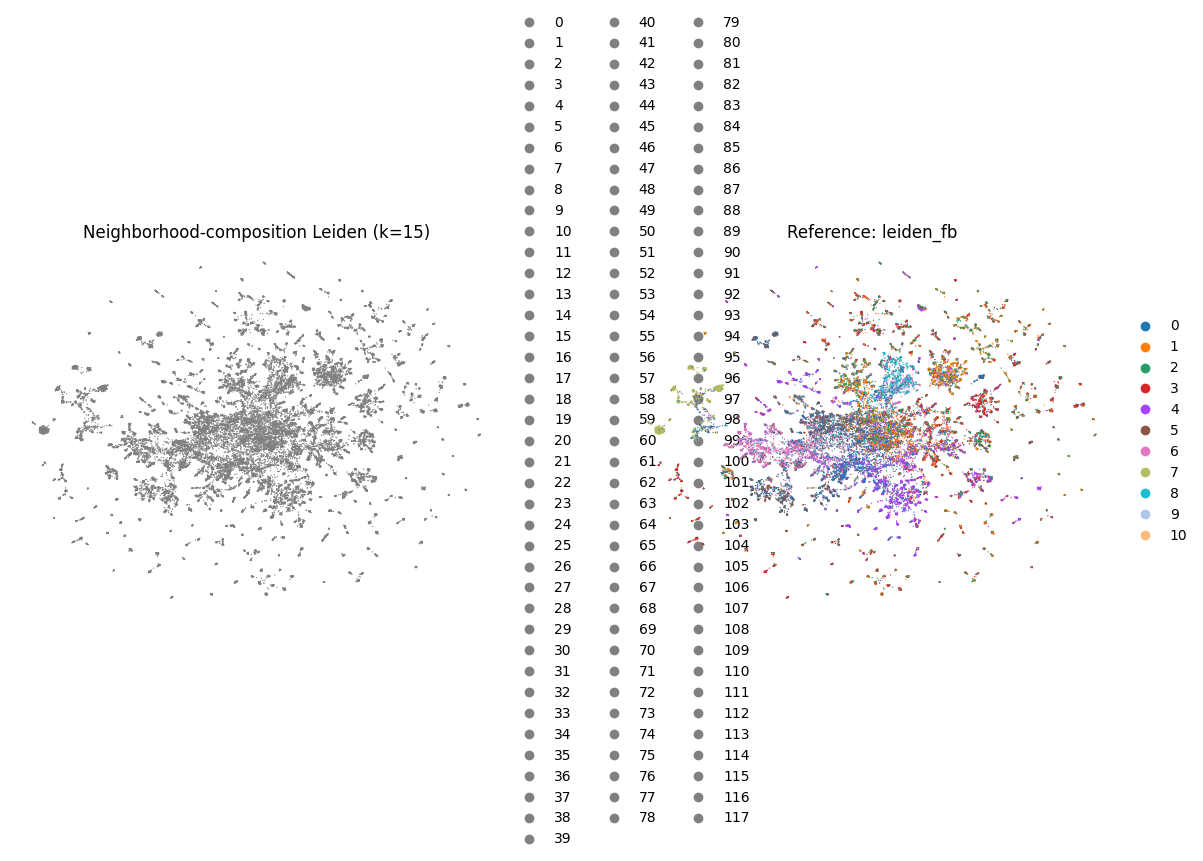

In [14]:
# Keep the UMAP under a stable name
adata_hc_fb.obsm["X_umap_nbhd_fb"] = adata_hc_fb.obsm["X_umap"].copy()

# 3) Quick visualization: new neighborhood-driven subclusters
sc.pl.embedding(
    adata_hc_fb, basis="X_umap_nbhd_fb",
    color=["leiden_nbhd_fb", focal_col],
    title=[f"Neighborhood-composition Leiden (k={k})",
           f"Reference: {focal_col}"],
    ncols=2, frameon=False
)

# Cell Clusters (Expression + Neighborhood)

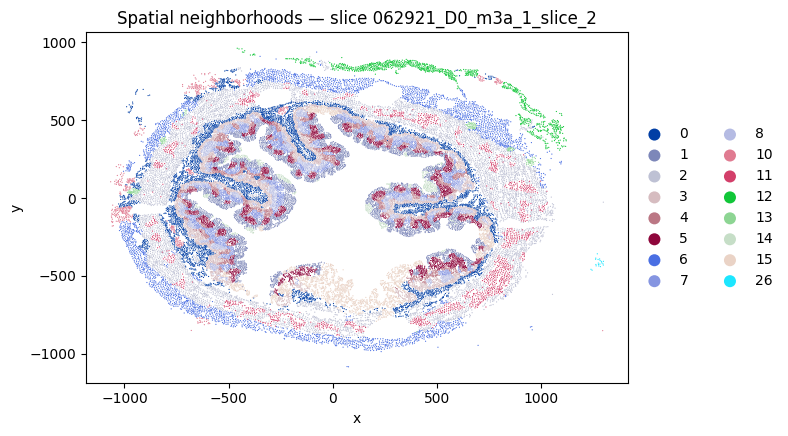

In [7]:
# Spatial plot for one slice
slice0 = adata_hc.obs["Slice_ID"].unique()[0]
adata_slice = adata_hc[adata_hc.obs["Slice_ID"] == slice0].copy()
sc.pl.scatter(
    adata_slice,
    x="x",
    y="y",
    color="neighborhood",
    size=3,
    alpha=1,
    title=f"Spatial neighborhoods — slice {slice0}",
    legend_loc="right margin"
)

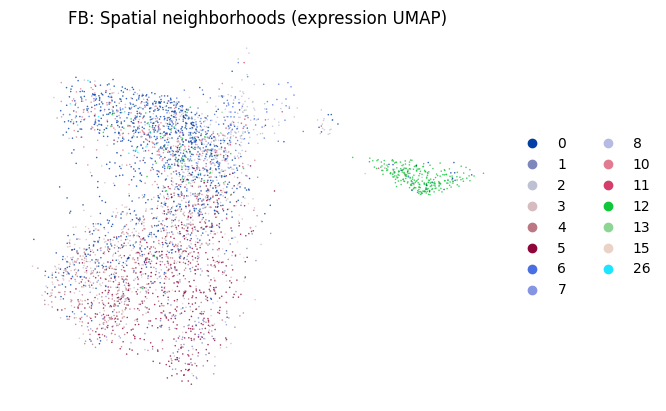

In [12]:
# umap of adata_hc_fb with neighborhood colors
adata_hc_fb_slice = adata_hc_fb[adata_hc_fb.obs["Slice_ID"] == slice0].copy()
sc.pl.embedding(
    adata_hc_fb_slice,
    basis='X_umap_expr',
    color='neighborhood',
    title='FB: Spatial neighborhoods (expression UMAP)',
    size=5,
    alpha=0.8,
    frameon=False,
    na_color='lightgray',
    legend_loc='right margin'
)

/var/folders/t3/473q526951s_6zvhy3t8bxzm0000gn/T/ipykernel_10061/1376072810.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()         # Adjust layout to prevent clipping


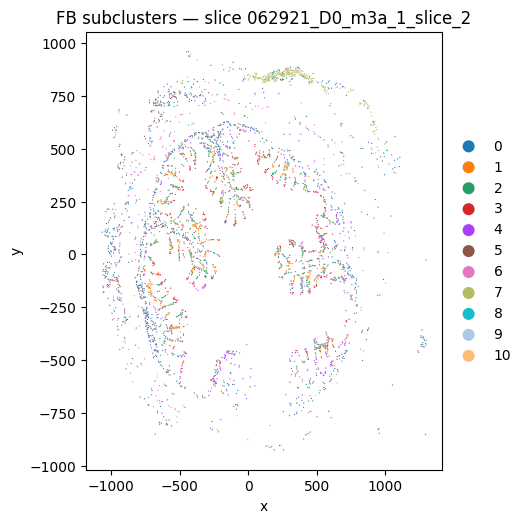

In [23]:
# plot slice adata_hc_fb_slice with color by fibroblast subclusters and save with dpi 500
sc.pl.scatter(
    adata_hc_fb_slice,
    x="x",
    y="y",
    color="leiden_fb",
    size=3,
    alpha=1,
    title=f"FB subclusters — slice {slice0}",
    legend_loc="right margin",
    show=False
)
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.tight_layout()         # Adjust layout to prevent clipping
plt.savefig(f"FB_subclusters_slice_{slice0}_spatial.png", dpi=500)

In [48]:
print(adata_hc.uns['Tier1_colors'])

['#1f77b4' '#ff7f0e' '#2ca02c' '#d62728' '#9467bd' '#8c564b' '#e377c2'
 '#7f7f7f']
